In [153]:
%matplotlib inline

# Read in the data
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [154]:
# Read in the surveys
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [155]:
# Add DBN columns
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [156]:
# Convert columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [157]:
# Condense datasets
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [158]:
# Convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

In [159]:
# Combine the datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [160]:
# Add a school district column for mapping

def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [161]:
# Find correlations
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations[survey_fields].sort_values(ascending=False, na_position='last'))

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
DBN                NaN
eng_t_10           NaN
Name: sat_score, dtype: float64


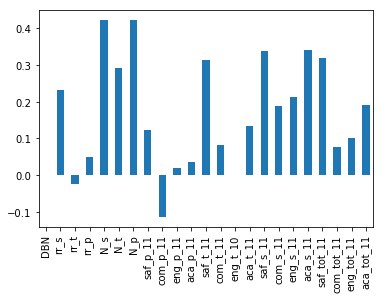

23


In [166]:
# Plotting survey correlations

import matplotlib.pyplot as plt
correlations[survey_fields].plot.bar()
plt.show()
print(correlations[survey_fields].size)

### <font color=blue>The following Survey Fields had the best coorelation to SAT scores.</font>


| Field | Abv | r value |
| :----- | :----- | :----- |
|Number of student respondents| N_s | 0.423463 |
|Number of parent respondents| N_p | 0.421530 |
|Academic expectations score based on student responses | aca_s_11 | 0.339435 |
|Safety and Respect score based on student responses | saf_s_11 | 0.337639 |
|Safety and Respect total score | saf_tot_11 | 0.318753 |
| Safety and Respect score based on teacher responses| saf_t_11 | 0.313810 |
<br>
<font color=red>Safety and respect seem to coorelate well with SAT scores.</font>
<br>
<font color=red>3 of the top 6 correlating survey fields are related to safety and respect</font>